<a href="https://colab.research.google.com/github/nafis-neehal/ML_PROJ_RPI/blob/main/HW5/HW5_1a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1a: CNN Model for CIFAR10 Dataset Classification
In this task, I have built a CNN model from scratch for performing classification task on CIFAR10. 

Dataset: Cifar10 https://pytorch.org/vision/stable/datasets.html \\
References: 
- https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html 
- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html 
- https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html 
- https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html 

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 

import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from tqdm import tqdm 
import time, copy
import pickle
import seaborn as sns

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Data Preprocessing, Data Loader and sample display
Here I have used simple transformations on the whole data, transformed them into tensor and then normalized the data so that i ranges between [-1,1]. \\
I have then created three separate dataloaders for Train, Validation and Test batches with batch size 128. \\
I have used CIFAR10 image dataset for this problem. The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. We have used validation size of 10% of the training set.

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

batch_size = 128

train    = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

validation_size = int(train.data.shape[0] * 0.10)
train_size = int(train.data.shape[0] - validation_size)

trainset, validset = torch.utils.data.random_split(train, [train_size,validation_size])
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle=True, num_workers=4)

testset     = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader  =  torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


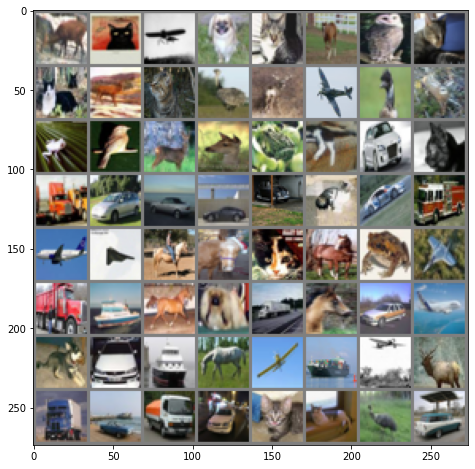

In [9]:
def imgshow(img):
  img = img/2 + 0.5 
  numpy_img = img.numpy()
  plt.figure(figsize=(8,8))
  plt.imshow(np.transpose(numpy_img,(1,2,0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images[:64]))

# CNN Architecture
I have used two conv layers with maxpooling. Based on literature stacking groups of conv layers and max pooling works best for classification problems with CNN. I have used 20% dropout for layer regularization. Finally after two conv-pool stacked layers we have three dense layers. The final output layer has 10 nodes for 10 different classes in CIFAR10. We have used standard SGD optimizer and Cross Entropy Loss.

In [10]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 5, padding="same")   
    self.pool  = nn.MaxPool2d(2, 2)         
    self.drop  = nn.Dropout(0.2)             
    self.conv2 = nn.Conv2d(16, 64, 5, padding="same")  
    self.fc1   = nn.Linear(64*8*8, 256)
    self.fc2   = nn.Linear(256, 64)
    self.fc3   = nn.Linear(64, 10) 

  def forward(self, x):
    x = self.conv1(x)         #output 32x32x6
    x = F.relu(x)             #output 32x32x6
    x = self.pool(x)          #output 16x16x6
    x = self.conv2(x)         #output 16x16x16
    x = F.relu(x)             #output 16x16x16
    x = self.pool(x)          #output 8x8x16
    x = torch.flatten(x, 1)   #flatten all dimension except batch
    x = self.drop(F.relu(self.fc1(x)))
    x = self.drop(F.relu(self.fc2(x)))
    x = self.fc3(x)
    return x

model = ConvNet()
model.to(device)
model

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training
We perform the training with 20 epochs. Everytime we train on one batch, we measure the validation score and keep tabs on both losses and accuracies for training and validation. After each 50 iterations of batches, we check the running average of accuracies and losses and if the model improves on validation set, we then save the model state as the current best model state. After the whole training is done, we reload the saved best model state and evaluate that on training set. We finally then save model history, model best state offline for future use. 

In [ ]:
#args = model path, history path
def train_or_load(model, perform, *args):

  if perform=="train":

    best_weights = copy.deepcopy(model.state_dict())
    best_val_acc = 0 
    stat_in_each_batch = 50
    EPOCHS = 20

    tr_acc_hist   = []
    tr_loss_hist  = []
    val_loss_hist = []
    val_acc_hist  = []

    since = time.time()

    for epoch in range(EPOCHS):  # loop over the dataset multiple times

        tr_running_loss = 0.0
        tr_running_corr = 0

        for i, data in tqdm(enumerate(trainloader)):
            # get the inputs; data is a list of [inputs, labels]
            tr_inputs, tr_labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            tr_outputs = model(tr_inputs)
            loss = criterion(tr_outputs, tr_labels)
            loss.backward()
            optimizer.step()

            # print statistics
            tr_running_loss += loss.item() * tr_inputs.size(0)
            _, tr_preds = torch.max(tr_outputs, 1)
            tr_running_corr += torch.sum(tr_preds==tr_labels.data)

            # #gpu memory clean
            tr_inputs.detach()
            tr_labels.detach()
            tr_outputs.detach()

            if (i+1) % stat_in_each_batch == 0:
              with torch.no_grad():
                v_loss = 0.0
                v_corr = 0
                for j, data in enumerate(validloader):
                  v_inputs, v_labels = data[0].to(device), data[1].to(device)
                  v_outputs = model(v_inputs)
                  loss = criterion(v_outputs, v_labels)

                  _, v_preds = torch.max(v_outputs, 1)
                  v_loss += loss.item() * v_inputs.size(0)
                  v_corr += torch.sum(v_preds==v_labels.data)
              
              #placeholder
              val_acc   = v_corr/len(validloader.dataset)
              tr_acc    = tr_running_corr / (stat_in_each_batch*batch_size) 
              val_loss  = v_loss/len(validloader.dataset)
              tr_loss   = tr_running_loss/(stat_in_each_batch*batch_size)

              #print stat
              print(f"\n Epoch: {epoch} Batch: {(i+1)} Train Loss: {tr_loss} Train Acc: {tr_acc} Val Loss: {val_loss} Val Acc: {val_acc}")
              
              #make sum 0
              tr_running_loss = 0.0
              tr_running_corr = 0

              #save history
              tr_acc_hist.append(tr_acc)
              tr_loss_hist.append(tr_loss)
              val_loss_hist.append(val_loss)
              val_acc_hist.append(val_acc)

              #model state transfer
              if val_acc > best_val_acc:
                best_val_acc = val_acc 
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:4f}'.format(best_val_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    #history
    tr_acc_hist = [x.cpu().item() for x in tr_acc_hist]
    val_acc_hist = [x.cpu().item() for x in val_acc_hist] 
    history = {"Training Loss": tr_loss_hist, "Training Accuracy": tr_acc_hist, "Validation Loss": val_loss_hist, "Validation Accuracy": val_acc_hist}

    #save model
    torch.save(model.state_dict(), args[0])

    #save history
    with open(args[1], 'wb') as f:
      pickle.dump(history, f)


  elif perform=="load":
    PATH = args[0]
    model.load_state_dict(torch.load(PATH))

    with open(args[1], 'rb') as f:
      history = pickle.load(f)

  return model, history





In [ ]:
#model path
model_PATH = './drive/MyDrive/ML Project Course/HW5/cifar_net.pth'
history_PATH = "./drive/MyDrive/ML Project Course/HW5/history_5_1a.pkl"

In [ ]:
model, history = train_or_load(model, "train", *[model_PATH, history_PATH])

58it [00:02, 12.88it/s]


 Epoch: 0 Batch: 50 Train Loss: 2.3043020486831667 Train Acc: 0.10749999433755875 Val Loss: 2.303774356842041 Val Acc: 0.10199999809265137


108it [00:05, 13.59it/s]


 Epoch: 0 Batch: 100 Train Loss: 2.3017806434631347 Train Acc: 0.12109375 Val Loss: 2.3008315563201904 Val Acc: 0.125


157it [00:08, 13.53it/s]


 Epoch: 0 Batch: 150 Train Loss: 2.298281469345093 Train Acc: 0.14171874523162842 Val Loss: 2.298253297805786 Val Acc: 0.13759998977184296


210it [00:10, 14.50it/s]


 Epoch: 0 Batch: 200 Train Loss: 2.296352801322937 Train Acc: 0.15796874463558197 Val Loss: 2.294710159301758 Val Acc: 0.1565999984741211


260it [00:13, 13.19it/s]


 Epoch: 0 Batch: 250 Train Loss: 2.291641979217529 Train Acc: 0.16359373927116394 Val Loss: 2.290208339691162 Val Acc: 0.1648000031709671


309it [00:15, 13.73it/s]


 Epoch: 0 Batch: 300 Train Loss: 2.2873549842834473 Train Acc: 0.17031249403953552 Val Loss: 2.2842512130737305 Val Acc: 0.1703999936580658


352it [00:17, 19.70it/s]


 Epoch: 0 Batch: 350 Train Loss: 2.2795888900756838 Train Acc: 0.17687499523162842 Val Loss: 2.275545358657837 Val Acc: 0.17059999704360962



57it [00:02, 12.54it/s]


 Epoch: 1 Batch: 50 Train Loss: 2.268401889801025 Train Acc: 0.19093748927116394 Val Loss: 2.260305881500244 Val Acc: 0.1931999921798706


110it [00:05, 14.09it/s]


 Epoch: 1 Batch: 100 Train Loss: 2.2521321678161623 Train Acc: 0.20734374225139618 Val Loss: 2.2390055656433105 Val Acc: 0.2078000009059906


160it [00:07, 14.58it/s]


 Epoch: 1 Batch: 150 Train Loss: 2.2247464656829834 Train Acc: 0.21671874821186066 Val Loss: 2.208785057067871 Val Acc: 0.20999999344348907


211it [00:10, 14.46it/s]


 Epoch: 1 Batch: 200 Train Loss: 2.197668972015381 Train Acc: 0.21265624463558197 Val Loss: 2.17209792137146 Val Acc: 0.21159999072551727


262it [00:12, 14.50it/s]


 Epoch: 1 Batch: 250 Train Loss: 2.150694284439087 Train Acc: 0.23156249523162842 Val Loss: 2.136369228363037 Val Acc: 0.21519999206066132


307it [00:15, 13.86it/s]


 Epoch: 1 Batch: 300 Train Loss: 2.1171396923065187 Train Acc: 0.22874999046325684 Val Loss: 2.101573944091797 Val Acc: 0.23119999468326569


352it [00:17, 20.06it/s]


 Epoch: 1 Batch: 350 Train Loss: 2.076154062747955 Train Acc: 0.24171873927116394 Val Loss: 2.0587522983551025 Val Acc: 0.24779999256134033



63it [00:02, 16.20it/s]


 Epoch: 2 Batch: 50 Train Loss: 2.0508669805526734 Train Acc: 0.2487500011920929 Val Loss: 2.0333776473999023 Val Acc: 0.25380000472068787


111it [00:05, 14.20it/s]


 Epoch: 2 Batch: 100 Train Loss: 2.036818056106567 Train Acc: 0.2549999952316284 Val Loss: 2.012497901916504 Val Acc: 0.2572000026702881


161it [00:07, 14.07it/s]


 Epoch: 2 Batch: 150 Train Loss: 2.0004431056976317 Train Acc: 0.27031248807907104 Val Loss: 1.9873414039611816 Val Acc: 0.2703999876976013


209it [00:10, 13.20it/s]


 Epoch: 2 Batch: 200 Train Loss: 1.977420666217804 Train Acc: 0.28328123688697815 Val Loss: 1.9768626689910889 Val Acc: 0.2703999876976013


259it [00:12, 14.36it/s]


 Epoch: 2 Batch: 250 Train Loss: 1.9711044764518737 Train Acc: 0.27734375 Val Loss: 1.9612888097763062 Val Acc: 0.274399995803833


308it [00:15, 14.50it/s]


 Epoch: 2 Batch: 300 Train Loss: 1.943130943775177 Train Acc: 0.2853125035762787 Val Loss: 1.9422527551651 Val Acc: 0.2895999848842621


352it [00:17, 20.18it/s]


 Epoch: 2 Batch: 350 Train Loss: 1.9243839740753175 Train Acc: 0.30265623331069946 Val Loss: 1.9232285022735596 Val Acc: 0.2913999855518341



62it [00:02, 15.41it/s]


 Epoch: 3 Batch: 50 Train Loss: 1.9151875591278076 Train Acc: 0.3076562285423279 Val Loss: 1.905410885810852 Val Acc: 0.3041999936103821


112it [00:05, 14.43it/s]


 Epoch: 3 Batch: 100 Train Loss: 1.8912871646881104 Train Acc: 0.31640625 Val Loss: 1.8877111673355103 Val Acc: 0.3100000023841858


160it [00:07, 15.45it/s]


 Epoch: 3 Batch: 150 Train Loss: 1.8795630741119385 Train Acc: 0.3148437440395355 Val Loss: 1.8711689710617065 Val Acc: 0.32739999890327454


210it [00:10, 14.34it/s]


 Epoch: 3 Batch: 200 Train Loss: 1.8715084743499757 Train Acc: 0.3317187428474426 Val Loss: 1.85789155960083 Val Acc: 0.32499998807907104


259it [00:12, 14.30it/s]


 Epoch: 3 Batch: 250 Train Loss: 1.8470232772827149 Train Acc: 0.33781248331069946 Val Loss: 1.842923641204834 Val Acc: 0.3353999853134155


312it [00:15, 15.07it/s]


 Epoch: 3 Batch: 300 Train Loss: 1.8210432291030885 Train Acc: 0.3349999785423279 Val Loss: 1.8240638971328735 Val Acc: 0.33059999346733093


352it [00:17, 20.05it/s]


 Epoch: 3 Batch: 350 Train Loss: 1.80352543592453 Train Acc: 0.3473437428474426 Val Loss: 1.797057867050171 Val Acc: 0.34139999747276306



61it [00:02, 15.23it/s]


 Epoch: 4 Batch: 50 Train Loss: 1.7859199571609496 Train Acc: 0.3478125035762787 Val Loss: 1.7803726196289062 Val Acc: 0.3531999886035919


109it [00:05, 14.27it/s]


 Epoch: 4 Batch: 100 Train Loss: 1.7857488083839417 Train Acc: 0.3464062511920929 Val Loss: 1.768032193183899 Val Acc: 0.34779998660087585


157it [00:07, 12.91it/s]


 Epoch: 4 Batch: 150 Train Loss: 1.757174654006958 Train Acc: 0.35984373092651367 Val Loss: 1.7584890127182007 Val Acc: 0.3612000048160553


207it [00:10, 13.57it/s]


 Epoch: 4 Batch: 200 Train Loss: 1.7506220054626465 Train Acc: 0.3570312559604645 Val Loss: 1.7406283617019653 Val Acc: 0.3595999777317047


260it [00:12, 14.36it/s]


 Epoch: 4 Batch: 250 Train Loss: 1.749647250175476 Train Acc: 0.3631249964237213 Val Loss: 1.7252918481826782 Val Acc: 0.37059998512268066


311it [00:15, 15.32it/s]


 Epoch: 4 Batch: 300 Train Loss: 1.7213120460510254 Train Acc: 0.3657812476158142 Val Loss: 1.7254443168640137 Val Acc: 0.3675999939441681


352it [00:17, 19.96it/s]


 Epoch: 4 Batch: 350 Train Loss: 1.693137104511261 Train Acc: 0.3828125 Val Loss: 1.708199381828308 Val Acc: 0.3789999783039093



61it [00:02, 14.54it/s]


 Epoch: 5 Batch: 50 Train Loss: 1.6937779378890991 Train Acc: 0.3839062452316284 Val Loss: 1.7023203372955322 Val Acc: 0.3831999897956848


109it [00:05, 12.99it/s]


 Epoch: 5 Batch: 100 Train Loss: 1.6834024953842164 Train Acc: 0.38359373807907104 Val Loss: 1.6795021295547485 Val Acc: 0.3863999843597412


160it [00:07, 14.62it/s]


 Epoch: 5 Batch: 150 Train Loss: 1.6791561722755433 Train Acc: 0.39281249046325684 Val Loss: 1.6756902933120728 Val Acc: 0.38259997963905334


210it [00:10, 13.98it/s]


 Epoch: 5 Batch: 200 Train Loss: 1.6683888459205627 Train Acc: 0.3851562440395355 Val Loss: 1.655805230140686 Val Acc: 0.3861999809741974


257it [00:12, 14.85it/s]


 Epoch: 5 Batch: 250 Train Loss: 1.6635424971580506 Train Acc: 0.3890624940395355 Val Loss: 1.6541615724563599 Val Acc: 0.3999999761581421


309it [00:14, 15.38it/s]


 Epoch: 5 Batch: 300 Train Loss: 1.6592844080924989 Train Acc: 0.3984375 Val Loss: 1.648541808128357 Val Acc: 0.4016000032424927


352it [00:17, 20.35it/s]


 Epoch: 5 Batch: 350 Train Loss: 1.6547309613227845 Train Acc: 0.3934375047683716 Val Loss: 1.6383939981460571 Val Acc: 0.397599995136261



61it [00:02, 13.64it/s]


 Epoch: 6 Batch: 50 Train Loss: 1.62312344789505 Train Acc: 0.40562498569488525 Val Loss: 1.6293163299560547 Val Acc: 0.4023999869823456


109it [00:05, 13.84it/s]


 Epoch: 6 Batch: 100 Train Loss: 1.6268293857574463 Train Acc: 0.3962499797344208 Val Loss: 1.621393084526062 Val Acc: 0.4039999842643738


160it [00:07, 13.25it/s]


 Epoch: 6 Batch: 150 Train Loss: 1.6087258648872376 Train Acc: 0.4154687523841858 Val Loss: 1.6098347902297974 Val Acc: 0.40779998898506165


208it [00:10, 12.97it/s]


 Epoch: 6 Batch: 200 Train Loss: 1.6194824552536011 Train Acc: 0.41203123331069946 Val Loss: 1.5996856689453125 Val Acc: 0.4129999876022339


259it [00:12, 14.77it/s]


 Epoch: 6 Batch: 250 Train Loss: 1.589344596862793 Train Acc: 0.42015624046325684 Val Loss: 1.597802758216858 Val Acc: 0.41419997811317444


307it [00:15, 13.16it/s]


 Epoch: 6 Batch: 300 Train Loss: 1.5810699772834778 Train Acc: 0.42265623807907104 Val Loss: 1.5904502868652344 Val Acc: 0.41579997539520264


352it [00:17, 19.64it/s]


 Epoch: 6 Batch: 350 Train Loss: 1.5935215950012207 Train Acc: 0.40718749165534973 Val Loss: 1.5733153820037842 Val Acc: 0.4277999997138977



62it [00:02, 14.47it/s]


 Epoch: 7 Batch: 50 Train Loss: 1.5781918001174926 Train Acc: 0.4273437261581421 Val Loss: 1.5783799886703491 Val Acc: 0.42100000381469727


109it [00:05, 13.03it/s]


 Epoch: 7 Batch: 100 Train Loss: 1.558700876235962 Train Acc: 0.4389062523841858 Val Loss: 1.5723100900650024 Val Acc: 0.4262000024318695


162it [00:07, 14.91it/s]


 Epoch: 7 Batch: 150 Train Loss: 1.5580575799942016 Train Acc: 0.4314062297344208 Val Loss: 1.5570238828659058 Val Acc: 0.4293999969959259


209it [00:10, 13.60it/s]


 Epoch: 7 Batch: 200 Train Loss: 1.5604153299331665 Train Acc: 0.4334374964237213 Val Loss: 1.5591760873794556 Val Acc: 0.42579999566078186


262it [00:12, 14.52it/s]


 Epoch: 7 Batch: 250 Train Loss: 1.5551915287971496 Train Acc: 0.4389062523841858 Val Loss: 1.5503175258636475 Val Acc: 0.4339999854564667


312it [00:15, 14.08it/s]


 Epoch: 7 Batch: 300 Train Loss: 1.5280569863319398 Train Acc: 0.44578123092651367 Val Loss: 1.5324642658233643 Val Acc: 0.44039997458457947


352it [00:17, 19.97it/s]


 Epoch: 7 Batch: 350 Train Loss: 1.5501533007621766 Train Acc: 0.43359375 Val Loss: 1.5317977666854858 Val Acc: 0.4423999786376953



57it [00:02, 13.27it/s]


 Epoch: 8 Batch: 50 Train Loss: 1.529406383037567 Train Acc: 0.4518750011920929 Val Loss: 1.526000738143921 Val Acc: 0.4389999806880951


110it [00:05, 13.81it/s]


 Epoch: 8 Batch: 100 Train Loss: 1.523248448371887 Train Acc: 0.44234374165534973 Val Loss: 1.5232763290405273 Val Acc: 0.44099998474121094


159it [00:07, 12.88it/s]


 Epoch: 8 Batch: 150 Train Loss: 1.5290740871429442 Train Acc: 0.4529687464237213 Val Loss: 1.5256825685501099 Val Acc: 0.436599999666214


208it [00:10, 13.70it/s]


 Epoch: 8 Batch: 200 Train Loss: 1.5088115072250365 Train Acc: 0.4467187523841858 Val Loss: 1.5083509683609009 Val Acc: 0.44599997997283936


259it [00:12, 15.40it/s]


 Epoch: 8 Batch: 250 Train Loss: 1.5130218076705932 Train Acc: 0.45515623688697815 Val Loss: 1.5009455680847168 Val Acc: 0.4509999752044678


305it [00:15, 12.16it/s]


 Epoch: 8 Batch: 300 Train Loss: 1.4904094243049621 Train Acc: 0.45890623331069946 Val Loss: 1.5118318796157837 Val Acc: 0.44839999079704285


352it [00:17, 19.97it/s]


 Epoch: 8 Batch: 350 Train Loss: 1.48131813287735 Train Acc: 0.46406248211860657 Val Loss: 1.4945229291915894 Val Acc: 0.4479999840259552



58it [00:02, 15.04it/s]


 Epoch: 9 Batch: 50 Train Loss: 1.4932243514060974 Train Acc: 0.46140623092651367 Val Loss: 1.4982901811599731 Val Acc: 0.45399999618530273


109it [00:05, 14.35it/s]


 Epoch: 9 Batch: 100 Train Loss: 1.490240488052368 Train Acc: 0.45703125 Val Loss: 1.489098072052002 Val Acc: 0.4527999758720398


158it [00:07, 13.47it/s]


 Epoch: 9 Batch: 150 Train Loss: 1.4571812176704406 Train Acc: 0.4646874964237213 Val Loss: 1.4759920835494995 Val Acc: 0.46779999136924744


209it [00:10, 13.96it/s]


 Epoch: 9 Batch: 200 Train Loss: 1.4841819500923157 Train Acc: 0.46015623211860657 Val Loss: 1.4766156673431396 Val Acc: 0.4619999825954437


258it [00:12, 13.92it/s]


 Epoch: 9 Batch: 250 Train Loss: 1.4608602547645568 Train Acc: 0.4710937440395355 Val Loss: 1.4619089365005493 Val Acc: 0.46539998054504395


311it [00:15, 13.80it/s]


 Epoch: 9 Batch: 300 Train Loss: 1.4548604702949524 Train Acc: 0.47203123569488525 Val Loss: 1.4697729349136353 Val Acc: 0.4649999737739563


352it [00:17, 20.17it/s]


 Epoch: 9 Batch: 350 Train Loss: 1.449153778553009 Train Acc: 0.48374998569488525 Val Loss: 1.4814594984054565 Val Acc: 0.46459999680519104



56it [00:02, 13.15it/s]


 Epoch: 10 Batch: 50 Train Loss: 1.4515493869781495 Train Acc: 0.47718748450279236 Val Loss: 1.4662202596664429 Val Acc: 0.4755999743938446


112it [00:05, 14.80it/s]


 Epoch: 10 Batch: 100 Train Loss: 1.440869565010071 Train Acc: 0.47734373807907104 Val Loss: 1.44423246383667 Val Acc: 0.4761999845504761


159it [00:07, 14.25it/s]


 Epoch: 10 Batch: 150 Train Loss: 1.4388553929328918 Train Acc: 0.47984373569488525 Val Loss: 1.4347436428070068 Val Acc: 0.4777999818325043


209it [00:10, 13.74it/s]


 Epoch: 10 Batch: 200 Train Loss: 1.433996660709381 Train Acc: 0.4834374785423279 Val Loss: 1.4634747505187988 Val Acc: 0.46719998121261597


262it [00:12, 15.07it/s]


 Epoch: 10 Batch: 250 Train Loss: 1.4389713597297669 Train Acc: 0.4779687523841858 Val Loss: 1.4346433877944946 Val Acc: 0.4745999872684479


310it [00:15, 13.80it/s]


 Epoch: 10 Batch: 300 Train Loss: 1.3993642258644103 Train Acc: 0.5093749761581421 Val Loss: 1.419264793395996 Val Acc: 0.48579999804496765


352it [00:17, 19.97it/s]


 Epoch: 10 Batch: 350 Train Loss: 1.4283437037467956 Train Acc: 0.4840624928474426 Val Loss: 1.4126147031784058 Val Acc: 0.48319998383522034



56it [00:02, 12.81it/s]


 Epoch: 11 Batch: 50 Train Loss: 1.3919313836097718 Train Acc: 0.4946874976158142 Val Loss: 1.4237090349197388 Val Acc: 0.48339998722076416


111it [00:05, 13.77it/s]


 Epoch: 11 Batch: 100 Train Loss: 1.398537793159485 Train Acc: 0.4985937476158142 Val Loss: 1.4112190008163452 Val Acc: 0.48240000009536743


160it [00:07, 13.73it/s]


 Epoch: 11 Batch: 150 Train Loss: 1.3961440896987916 Train Acc: 0.49437499046325684 Val Loss: 1.419703722000122 Val Acc: 0.48420000076293945


211it [00:10, 14.05it/s]


 Epoch: 11 Batch: 200 Train Loss: 1.4020914030075073 Train Acc: 0.4896875023841858 Val Loss: 1.413711667060852 Val Acc: 0.4860000014305115


259it [00:12, 13.56it/s]


 Epoch: 11 Batch: 250 Train Loss: 1.4018992328643798 Train Acc: 0.49671873450279236 Val Loss: 1.3934653997421265 Val Acc: 0.49219998717308044


311it [00:15, 13.54it/s]


 Epoch: 11 Batch: 300 Train Loss: 1.3998601627349854 Train Acc: 0.49015623331069946 Val Loss: 1.3933185338974 Val Acc: 0.4875999987125397


352it [00:17, 20.08it/s]


 Epoch: 11 Batch: 350 Train Loss: 1.3984542489051819 Train Acc: 0.5090624690055847 Val Loss: 1.3880120515823364 Val Acc: 0.4967999756336212



62it [00:02, 14.54it/s]


 Epoch: 12 Batch: 50 Train Loss: 1.3812324905395508 Train Acc: 0.5032812356948853 Val Loss: 1.3860130310058594 Val Acc: 0.4927999973297119


111it [00:05, 14.11it/s]


 Epoch: 12 Batch: 100 Train Loss: 1.3485833525657653 Train Acc: 0.5167187452316284 Val Loss: 1.389904499053955 Val Acc: 0.49719998240470886


157it [00:07, 13.97it/s]


 Epoch: 12 Batch: 150 Train Loss: 1.38752245426178 Train Acc: 0.4985937476158142 Val Loss: 1.3967945575714111 Val Acc: 0.49959999322891235


209it [00:10, 13.38it/s]


 Epoch: 12 Batch: 200 Train Loss: 1.3480870056152343 Train Acc: 0.5095312595367432 Val Loss: 1.3673584461212158 Val Acc: 0.4959999918937683


259it [00:12, 13.78it/s]


 Epoch: 12 Batch: 250 Train Loss: 1.3436592864990233 Train Acc: 0.5093749761581421 Val Loss: 1.3821451663970947 Val Acc: 0.498199999332428


310it [00:15, 14.51it/s]


 Epoch: 12 Batch: 300 Train Loss: 1.376648588180542 Train Acc: 0.4985937476158142 Val Loss: 1.3569581508636475 Val Acc: 0.5063999891281128


352it [00:17, 20.09it/s]


 Epoch: 12 Batch: 350 Train Loss: 1.3448197722434998 Train Acc: 0.5232812166213989 Val Loss: 1.352843999862671 Val Acc: 0.5054000020027161



60it [00:02, 14.60it/s]


 Epoch: 13 Batch: 50 Train Loss: 1.3286342644691467 Train Acc: 0.524218738079071 Val Loss: 1.3597736358642578 Val Acc: 0.5115999579429626


111it [00:05, 14.71it/s]


 Epoch: 13 Batch: 100 Train Loss: 1.335646595954895 Train Acc: 0.5173437595367432 Val Loss: 1.3531519174575806 Val Acc: 0.5067999958992004


160it [00:07, 14.12it/s]


 Epoch: 13 Batch: 150 Train Loss: 1.312598671913147 Train Acc: 0.5315625071525574 Val Loss: 1.3561134338378906 Val Acc: 0.5101999640464783


210it [00:10, 13.29it/s]


 Epoch: 13 Batch: 200 Train Loss: 1.3289603424072265 Train Acc: 0.5224999785423279 Val Loss: 1.3407117128372192 Val Acc: 0.5126000046730042


258it [00:12, 12.80it/s]


 Epoch: 13 Batch: 250 Train Loss: 1.3143620920181274 Train Acc: 0.5314062237739563 Val Loss: 1.3439463376998901 Val Acc: 0.5167999863624573


312it [00:15, 13.77it/s]


 Epoch: 13 Batch: 300 Train Loss: 1.3149969100952148 Train Acc: 0.5374999642372131 Val Loss: 1.332487940788269 Val Acc: 0.5151999592781067


352it [00:17, 19.69it/s]


 Epoch: 13 Batch: 350 Train Loss: 1.3200335812568664 Train Acc: 0.5260937213897705 Val Loss: 1.326913595199585 Val Acc: 0.5151999592781067



61it [00:02, 14.31it/s]


 Epoch: 14 Batch: 50 Train Loss: 1.3079686903953551 Train Acc: 0.5321874618530273 Val Loss: 1.3287431001663208 Val Acc: 0.5112000107765198


111it [00:05, 14.22it/s]


 Epoch: 14 Batch: 100 Train Loss: 1.2913895487785338 Train Acc: 0.5360937118530273 Val Loss: 1.3274489641189575 Val Acc: 0.5221999883651733


158it [00:07, 12.65it/s]


 Epoch: 14 Batch: 150 Train Loss: 1.3102650237083435 Train Acc: 0.5321874618530273 Val Loss: 1.3292282819747925 Val Acc: 0.5115999579429626


210it [00:10, 14.62it/s]


 Epoch: 14 Batch: 200 Train Loss: 1.3029102087020874 Train Acc: 0.5348437428474426 Val Loss: 1.3156973123550415 Val Acc: 0.5257999897003174


259it [00:12, 14.07it/s]


 Epoch: 14 Batch: 250 Train Loss: 1.2961829900741577 Train Acc: 0.5426562428474426 Val Loss: 1.306870937347412 Val Acc: 0.5266000032424927


309it [00:15, 14.37it/s]


 Epoch: 14 Batch: 300 Train Loss: 1.2655934524536132 Train Acc: 0.546093761920929 Val Loss: 1.3058034181594849 Val Acc: 0.5338000059127808


352it [00:17, 19.91it/s]


 Epoch: 14 Batch: 350 Train Loss: 1.2651710677146912 Train Acc: 0.5459374785423279 Val Loss: 1.2971328496932983 Val Acc: 0.5306000113487244



57it [00:02, 13.87it/s]


 Epoch: 15 Batch: 50 Train Loss: 1.2811388206481933 Train Acc: 0.5392187237739563 Val Loss: 1.3075652122497559 Val Acc: 0.5313999652862549


112it [00:05, 15.59it/s]


 Epoch: 15 Batch: 100 Train Loss: 1.2603825187683106 Train Acc: 0.559374988079071 Val Loss: 1.2830965518951416 Val Acc: 0.5335999727249146


160it [00:07, 13.45it/s]


 Epoch: 15 Batch: 150 Train Loss: 1.2743377375602722 Train Acc: 0.5428124666213989 Val Loss: 1.295756220817566 Val Acc: 0.5315999984741211


208it [00:10, 12.82it/s]


 Epoch: 15 Batch: 200 Train Loss: 1.2452244782447814 Train Acc: 0.5509374737739563 Val Loss: 1.293155550956726 Val Acc: 0.5343999862670898


258it [00:12, 12.96it/s]


 Epoch: 15 Batch: 250 Train Loss: 1.2490719985961913 Train Acc: 0.55078125 Val Loss: 1.2818646430969238 Val Acc: 0.5291999578475952


310it [00:15, 14.21it/s]


 Epoch: 15 Batch: 300 Train Loss: 1.2364092111587524 Train Acc: 0.5601562261581421 Val Loss: 1.288907527923584 Val Acc: 0.5320000052452087


352it [00:17, 19.83it/s]


 Epoch: 15 Batch: 350 Train Loss: 1.2498809361457826 Train Acc: 0.5496875047683716 Val Loss: 1.2890971899032593 Val Acc: 0.5291999578475952



58it [00:02, 14.54it/s]


 Epoch: 16 Batch: 50 Train Loss: 1.2366370463371277 Train Acc: 0.5615624785423279 Val Loss: 1.2582427263259888 Val Acc: 0.543999969959259


111it [00:05, 13.21it/s]


 Epoch: 16 Batch: 100 Train Loss: 1.2370854687690735 Train Acc: 0.5609374642372131 Val Loss: 1.2710026502609253 Val Acc: 0.5453999638557434


161it [00:07, 14.99it/s]


 Epoch: 16 Batch: 150 Train Loss: 1.2420059180259704 Train Acc: 0.5503124594688416 Val Loss: 1.279412031173706 Val Acc: 0.5381999611854553


209it [00:10, 13.42it/s]


 Epoch: 16 Batch: 200 Train Loss: 1.2313368439674377 Train Acc: 0.5553125143051147 Val Loss: 1.2568745613098145 Val Acc: 0.5475999712944031


259it [00:12, 13.62it/s]


 Epoch: 16 Batch: 250 Train Loss: 1.2256843805313111 Train Acc: 0.5589062571525574 Val Loss: 1.2616307735443115 Val Acc: 0.5425999760627747


312it [00:15, 14.77it/s]


 Epoch: 16 Batch: 300 Train Loss: 1.2197473156452179 Train Acc: 0.5682812333106995 Val Loss: 1.2667293548583984 Val Acc: 0.5493999719619751


352it [00:17, 19.94it/s]


 Epoch: 16 Batch: 350 Train Loss: 1.2296639227867125 Train Acc: 0.5621874928474426 Val Loss: 1.2461678981781006 Val Acc: 0.5547999739646912



60it [00:02, 14.43it/s]


 Epoch: 17 Batch: 50 Train Loss: 1.2304170227050781 Train Acc: 0.5628125071525574 Val Loss: 1.2596852779388428 Val Acc: 0.545799970626831


107it [00:05, 12.44it/s]


 Epoch: 17 Batch: 100 Train Loss: 1.2295512557029724 Train Acc: 0.5567187666893005 Val Loss: 1.2522592544555664 Val Acc: 0.543999969959259


162it [00:07, 13.74it/s]


 Epoch: 17 Batch: 150 Train Loss: 1.1969948506355286 Train Acc: 0.5782812237739563 Val Loss: 1.236115574836731 Val Acc: 0.5577999949455261


211it [00:10, 13.51it/s]


 Epoch: 17 Batch: 200 Train Loss: 1.1825404584407806 Train Acc: 0.5757812261581421 Val Loss: 1.240191102027893 Val Acc: 0.5503999590873718


259it [00:12, 13.44it/s]


 Epoch: 17 Batch: 250 Train Loss: 1.1726541864871978 Train Acc: 0.5859375 Val Loss: 1.2251828908920288 Val Acc: 0.5618000030517578


306it [00:15, 13.11it/s]


 Epoch: 17 Batch: 300 Train Loss: 1.2247761225700378 Train Acc: 0.5631250143051147 Val Loss: 1.256486177444458 Val Acc: 0.5461999773979187


352it [00:17, 19.64it/s]


 Epoch: 17 Batch: 350 Train Loss: 1.204745192527771 Train Acc: 0.5754687190055847 Val Loss: 1.241731882095337 Val Acc: 0.5491999983787537



61it [00:02, 15.16it/s]


 Epoch: 18 Batch: 50 Train Loss: 1.1650397050380707 Train Acc: 0.5767187476158142 Val Loss: 1.2345281839370728 Val Acc: 0.5568000078201294


113it [00:05, 14.85it/s]


 Epoch: 18 Batch: 100 Train Loss: 1.167798490524292 Train Acc: 0.5779687166213989 Val Loss: 1.243648886680603 Val Acc: 0.5550000071525574


161it [00:07, 13.47it/s]


 Epoch: 18 Batch: 150 Train Loss: 1.18734250664711 Train Acc: 0.571093738079071 Val Loss: 1.2309787273406982 Val Acc: 0.5636000037193298


209it [00:10, 13.49it/s]


 Epoch: 18 Batch: 200 Train Loss: 1.1886187255382539 Train Acc: 0.577343761920929 Val Loss: 1.2090586423873901 Val Acc: 0.5627999901771545


261it [00:12, 15.03it/s]


 Epoch: 18 Batch: 250 Train Loss: 1.1826611399650573 Train Acc: 0.5951562523841858 Val Loss: 1.222088098526001 Val Acc: 0.5622000098228455


310it [00:15, 14.51it/s]


 Epoch: 18 Batch: 300 Train Loss: 1.150362082719803 Train Acc: 0.592968761920929 Val Loss: 1.2011686563491821 Val Acc: 0.5751999616622925


352it [00:17, 19.82it/s]


 Epoch: 18 Batch: 350 Train Loss: 1.163737916946411 Train Acc: 0.5793749690055847 Val Loss: 1.2181928157806396 Val Acc: 0.5619999766349792



62it [00:02, 15.15it/s]


 Epoch: 19 Batch: 50 Train Loss: 1.1500142550468444 Train Acc: 0.5924999713897705 Val Loss: 1.2057750225067139 Val Acc: 0.5643999576568604


111it [00:05, 13.99it/s]


 Epoch: 19 Batch: 100 Train Loss: 1.1420618104934692 Train Acc: 0.5940625071525574 Val Loss: 1.2085888385772705 Val Acc: 0.5659999847412109


160it [00:07, 13.47it/s]


 Epoch: 19 Batch: 150 Train Loss: 1.1455285608768464 Train Acc: 0.5931249856948853 Val Loss: 1.1965707540512085 Val Acc: 0.5676000118255615


210it [00:10, 14.47it/s]


 Epoch: 19 Batch: 200 Train Loss: 1.1579508101940155 Train Acc: 0.5942187309265137 Val Loss: 1.2015118598937988 Val Acc: 0.5699999928474426


260it [00:12, 14.83it/s]


 Epoch: 19 Batch: 250 Train Loss: 1.1313413286209106 Train Acc: 0.5881249904632568 Val Loss: 1.198152780532837 Val Acc: 0.5712000131607056


309it [00:15, 13.43it/s]


 Epoch: 19 Batch: 300 Train Loss: 1.157658885717392 Train Acc: 0.5881249904632568 Val Loss: 1.1907178163528442 Val Acc: 0.5767999887466431


352it [00:17, 19.74it/s]


 Epoch: 19 Batch: 350 Train Loss: 1.1550774824619294 Train Acc: 0.5837500095367432 Val Loss: 1.2038291692733765 Val Acc: 0.5701999664306641
Training complete in 5m 56s
Best Validation Accuracy: 0.576800


# Performance Evaluation
For training we got around 58% accuracy whereas in validation we got 57% accuracy. 

**Challenge:** The model performance obviously has room for improvement. The problem I faced with model tweaking and hyperparameter tuning is GPU runtime shortage. Colab doesn't offer free unlimited GPU and has cap limit on GPU usage. So it was very hard to tweak and retrain and check model everytime on this limited GPU capacity. Also, on CPU, it is near to impossible to train even a small vanilla CNN like this within a small time window. \\

## Performance on Test Data
On test data we also achieved around 57% accuracy, so model doesn't suffer from overfitting. 

In [ ]:
#Test Performance 
with torch.no_grad():
  test_loss = 0.0
  test_correct = 0

  for i, data in tqdm(enumerate(testloader)):
    te_inputs, te_labels = data[0].to(device), data[1].to(device)
    te_outputs = model(te_inputs)
    te_loss = criterion(te_outputs, te_labels)
    test_loss += te_loss.item() * te_inputs.size(0)

    _, te_pred = torch.max(te_outputs.data, 1)
    test_correct += (te_pred == te_labels).sum().item()

print(f"\nTest Loss: {test_loss/len(testloader.dataset):0.05f} Test Accuracy: {test_correct/len(testset):0.05f}")
    

79it [00:01, 45.61it/s]


Test Loss: 1.19325 Test Accuracy: 0.57750


## Plot History
If we look at the trend at the loss graph, it decreases monotonically. And in the accuracy graph, in increases monotonically. I can infer that this trend would continue and performance would have developed more if I had the resources to train the network more.

In [ ]:
history.keys()

dict_keys(['Training Loss', 'Training Accuracy', 'Validation Loss', 'Validation Accuracy'])

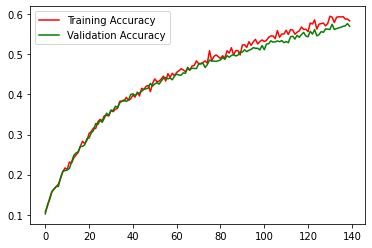

In [ ]:
plt.plot(history["Training Accuracy"], label="Training Accuracy", color="red")
plt.plot(history["Validation Accuracy"], label="Validation Accuracy", color="green")
plt.legend()
plt.show()

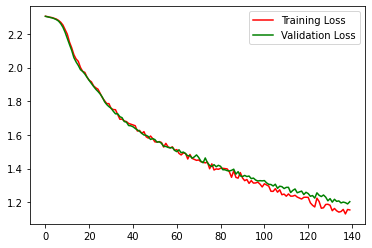

In [ ]:
plt.plot(history["Training Loss"], label="Training Loss", color="red")
plt.plot(history["Validation Loss"], label="Validation Loss", color="green")
plt.legend()
plt.show()

## Heatmap
This heatmap gives an idea how the model is performing on each class. Heatmap is produced using test data.

In [ ]:
classes = trainset.dataset.classes
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)

In [ ]:
import seaborn as sns
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for k in range(len(labels)):
            true_label = labels[k].item()
            predicted_label = predicted[k].item()
            heatmap.iloc[true_label,predicted_label] += 1

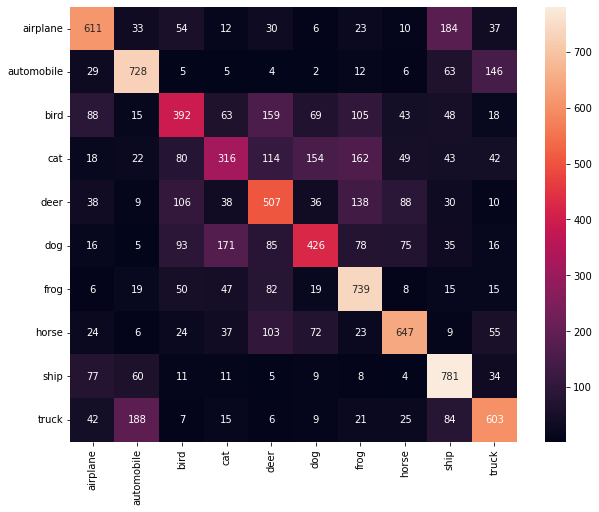

In [ ]:
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d")
plt.show()